In [1]:
from scripts.StreamProcessing import Stream_Data, ClimateChangeDataset # found in the scripts folder inside StreamProcessing.py. This class uses PySpark

PySpark found


https://berkeleyearth.org/data/

### A note on block 

These might take a while as PySpark attempts to download some additional files

In [2]:
# Initialize the Stream_Data Class using the topic name/s established in the kafka-config/kafka-config.ipynb and add the host of your kafka instance in the host parameter
emissions_config = Stream_Data(topics='ghg_data', host='localhost:9092')
e_session, query, emissions_df = emissions_config.getData()
#temperatures

/media/camagakhan/DATA/Repositories/BigDataProcessing/Assignment/BigDataProcessingClimateChange/notebooks/scripts/mysql-connector-j-8.0.33.jar
/media/camagakhan/DATA/Repositories/BigDataProcessing/Assignment/BigDataProcessingClimateChange/notebooks/scripts/graphframes-0.8.2-spark3.2-s_2.12.jar


23/05/17 23:11:26 WARN Utils: Your hostname, camagakhan-Inspiron-7577 resolves to a loopback address: 127.0.1.1; using 192.168.6.98 instead (on interface wlp60s0)
23/05/17 23:11:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/home/camagakhan/spark-3.4.0-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/camagakhan/.ivy2/cache
The jars for the packages stored in: /home/camagakhan/.ivy2/jars
org.apache.spark#spark-streaming-kafka-0-10_2.12 added as a dependency
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-cbe305f0-576d-4dfa-a054-e32dd85917ad;1.0
	confs: [default]
	found org.apache.spark#spark-streaming-kafka-0-10_2.12;3.2.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.2.0 in central
	found org.apache.kafka#kafka-clients;2.8.0 in central
	found org.lz4#lz4-java;1.7.1 in central
	found org.xerial.snappy#snappy-java;1.1.8.4 in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found org.apache.hadoop#hadoop-client-runtime;3.3.1 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.apache.hadoop#hadoop-client-api;3.3.1 in central
	found org.apache.htrace#htrace-core4;4.1.0-incubating in central
	found commons-logging#com

In [3]:
# Initialize the Stream_Data Class using the topic name/s established in the kafka-config/kafka-config.ipynb and add the host of your kafka instance in the host parameter
temperature_config = Stream_Data(topics='temperature', host='localhost:9092')
t_session, query_temperature, temperature_df = temperature_config.getData()

/media/camagakhan/DATA/Repositories/BigDataProcessing/Assignment/BigDataProcessingClimateChange/notebooks/scripts/mysql-connector-j-8.0.33.jar
/media/camagakhan/DATA/Repositories/BigDataProcessing/Assignment/BigDataProcessingClimateChange/notebooks/scripts/graphframes-0.8.2-spark3.2-s_2.12.jar


### NOTE
Everything is configered while initializing the PySpark Session in the ```StreamProcessing.py``` class. DO NOT remove the ```from graphframes import GraphFrame```, as the jar files are loaded while getting the data from the previous code block

In [4]:
from graphframes import GraphFrame
import findspark as tt
tt.init(emissions_config.getSpark_Path()) 
from pyspark.sql import functions as F
from pyspark.sql.functions import dense_rank
from pyspark.sql.window import Window

In [5]:
print(temperature_df)
print(emissions_df)

DataFrame[REF_AREA: string, Measure: string, UNIT_MEASURE: string, TIME_PERIOD: int, OBS_VALUE: double, REF_CODE: string]
DataFrame[Country: string, Pollutant: string, Year: int, Value: double]


In [6]:
temp_df = temperature_df.withColumnRenamed('REF_CODE','COUNTRY_CODE')
ghg_df = emissions_df.withColumnRenamed('Pollutant','POL')

myDataset = temp_df.join(ghg_df, (temp_df.REF_AREA == ghg_df.Country) & (temp_df.TIME_PERIOD == ghg_df.Year), 'inner')


myDataset = myDataset.select(temp_df.COUNTRY_CODE, ghg_df.Country,ghg_df.Year, temp_df.UNIT_MEASURE, temp_df.OBS_VALUE, ghg_df.POL, ghg_df.Value)

# ran into out of memory exception

# We'll be assigning the country_codes as ids to map relationships

Store the Dataset before we attempt to use models

In [7]:
config_train = Stream_Data(topics=None, host='localhost:9092')
config_train.storeData('climate_change', myDataset) # we are about to store the new dataset in a mySQL table

# Machine Learning Section.

In [8]:
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline

In the following code block we are setting up the Linear Regression to set up a model to predict the temperatures based on the given Green house Gases levels

In [27]:
assembler = VectorAssembler(inputCols=['Partition', 'Year', 'Value'], outputCol='features')
#scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
linear_regression = LinearRegression(labelCol='OBS_VALUE', featuresCol='features')
linear_regression.setMaxIter(50)
'''
    Stages

    1) Get the features of the model,
    2) apply training using linear regression. This uses the OBS_VALUE (which is the temperature value) as Y
'''
pipeline = Pipeline(stages=[assembler, linear_regression])

In [28]:
climate_change_df = ClimateChangeDataset().loadDataset()
climate_change_df.show()

/media/camagakhan/DATA/Repositories/BigDataProcessing/Assignment/BigDataProcessingClimateChange/notebooks/scripts/graphframes-0.8.2-spark3.2-s_2.12.jar
+------------+--------------------+----+------------------+---------+---+-------+
|COUNTRY_CODE|             Country|Year|      UNIT_MEASURE|OBS_VALUE|POL|  Value|
+------------+--------------------+----+------------------+---------+---+-------+
|         DZA|             Algeria|1995|C: Degrees celsius|    -0.08|GHG|  143.9|
|         AUS|           Australia|2013|C: Degrees celsius|     0.89|GHG| 554.25|
|         BHS|             Bahamas|1992|C: Degrees celsius|    -0.17|GHG|   2.79|
|         BHS|             Bahamas|1995|C: Degrees celsius|     0.09|GHG|   2.43|
|         BFA|        Burkina Faso|1996|C: Degrees celsius|     0.03|GHG|  27.27|
|         BDI|             Burundi|2011|C: Degrees celsius|     0.05|GHG|   1.71|
|         CAF|Central African R...|2014|C: Degrees celsius|     0.51|GHG|  48.84|
|         DJI|            Dj

In [29]:
climate_change_df = climate_change_df.withColumn('Partition', dense_rank().over(Window.partitionBy('COUNTRY_CODE').orderBy('Year')))
climate_change_df.show()

+------------+-----------+----+------------------+---------+---+-----+---------+
|COUNTRY_CODE|    Country|Year|      UNIT_MEASURE|OBS_VALUE|POL|Value|Partition|
+------------+-----------+----+------------------+---------+---+-----+---------+
|         AFG|Afghanistan|1990|C: Degrees celsius|     0.05|GHG| 9.58|        1|
|         AFG|Afghanistan|1991|C: Degrees celsius|    -0.96|GHG| 9.81|        2|
|         AFG|Afghanistan|1992|C: Degrees celsius|    -1.19|GHG| 9.03|        3|
|         AFG|Afghanistan|1993|C: Degrees celsius|    -0.67|GHG| 9.11|        4|
|         AFG|Afghanistan|1994|C: Degrees celsius|    -0.34|GHG| 9.15|        5|
|         AFG|Afghanistan|1995|C: Degrees celsius|    -0.46|GHG| 9.58|        6|
|         AFG|Afghanistan|1996|C: Degrees celsius|    -0.68|GHG|10.61|        7|
|         AFG|Afghanistan|1997|C: Degrees celsius|    -0.57|GHG|11.58|        8|
|         AFG|Afghanistan|1998|C: Degrees celsius|     0.47|GHG| 12.4|        9|
|         AFG|Afghanistan|19

In [30]:
train, test = climate_change_df.randomSplit([0.8, 0.2], seed=42)

## Correlation between Year and Temperature (Total emissions excluding LULUCF)

In [31]:
climate_change_df.stat.corr('Year', 'OBS_VALUE')

0.5408678020383351

## Correlation between Year and Emissions Value ('Total emissions excluding LULUCF')

In [32]:
climate_change_df.stat.corr('Year', 'Value')

0.02287905746167594

## Correlation between Temperature and Emissions Value (Total emissions excluding LULUCF)

In [33]:
climate_change_df.stat.corr('Value', 'OBS_VALUE')

0.0352072251213721

### Dataset Analysis

In [34]:
train.show()

+------------+-----------+----+------------------+---------+---+-----+---------+
|COUNTRY_CODE|    Country|Year|      UNIT_MEASURE|OBS_VALUE|POL|Value|Partition|
+------------+-----------+----+------------------+---------+---+-----+---------+
|         AFG|Afghanistan|1990|C: Degrees celsius|     0.05|GHG| 9.58|        1|
|         AFG|Afghanistan|1991|C: Degrees celsius|    -0.96|GHG| 9.81|        2|
|         AFG|Afghanistan|1993|C: Degrees celsius|    -0.67|GHG| 9.11|        4|
|         AFG|Afghanistan|1994|C: Degrees celsius|    -0.34|GHG| 9.15|        5|
|         AFG|Afghanistan|1995|C: Degrees celsius|    -0.46|GHG| 9.58|        6|
|         AFG|Afghanistan|1997|C: Degrees celsius|    -0.57|GHG|11.58|        8|
|         AFG|Afghanistan|1999|C: Degrees celsius|     0.38|GHG|13.28|       10|
|         AFG|Afghanistan|2000|C: Degrees celsius|      0.4|GHG| 11.5|       11|
|         AFG|Afghanistan|2001|C: Degrees celsius|     1.23|GHG|12.37|       12|
|         AFG|Afghanistan|20

In [35]:
val, test = test.randomSplit([.5, .5], seed=42)

In [36]:
val.show()

+------------+-----------+----+------------------+---------+---+------+---------+
|COUNTRY_CODE|    Country|Year|      UNIT_MEASURE|OBS_VALUE|POL| Value|Partition|
+------------+-----------+----+------------------+---------+---+------+---------+
|         AFG|Afghanistan|2003|C: Degrees celsius|      0.3|GHG| 15.65|       14|
|         AGO|     Angola|1995|C: Degrees celsius|     0.31|GHG| 76.32|        6|
|         AGO|     Angola|2007|C: Degrees celsius|     0.12|GHG| 117.2|       18|
|         AGO|     Angola|2011|C: Degrees celsius|    -0.12|GHG|126.65|       22|
|         ALB|    Albania|2007|C: Degrees celsius|     0.62|GHG|  7.75|       18|
|         AND|    Andorra|2012|C: Degrees celsius|      0.4|GHG|   0.6|       23|
|         AND|    Andorra|2017|C: Degrees celsius|     0.99|GHG|  0.59|       28|
|         ARG|  Argentina|2000|C: Degrees celsius|    -0.67|GHG|337.38|       11|
|         ARG|  Argentina|2004|C: Degrees celsius|     0.34|GHG|414.15|       15|
|         ARG|  

In [37]:
test.show()

+------------+--------------------+----+------------------+---------+---+------+---------+
|COUNTRY_CODE|             Country|Year|      UNIT_MEASURE|OBS_VALUE|POL| Value|Partition|
+------------+--------------------+----+------------------+---------+---+------+---------+
|         AFG|         Afghanistan|1992|C: Degrees celsius|    -1.19|GHG|  9.03|        3|
|         AFG|         Afghanistan|1996|C: Degrees celsius|    -0.68|GHG| 10.61|        7|
|         AFG|         Afghanistan|1998|C: Degrees celsius|     0.47|GHG|  12.4|        9|
|         AFG|         Afghanistan|2009|C: Degrees celsius|     0.16|GHG| 22.75|       20|
|         AFG|         Afghanistan|2013|C: Degrees celsius|     0.66|GHG| 26.77|       24|
|         AFG|         Afghanistan|2019|C: Degrees celsius|     0.78|GHG| 28.79|       30|
|         AGO|              Angola|2005|C: Degrees celsius|     0.47|GHG|114.87|       16|
|         AGO|              Angola|2006|C: Degrees celsius|    -0.27|GHG|112.77|       17|

In [38]:
dataset_count = (train.count(), val.count(), test.count())

In [39]:
import matplotlib.pyplot as plt

The plot shows how the dataset is split before being passed to the model.

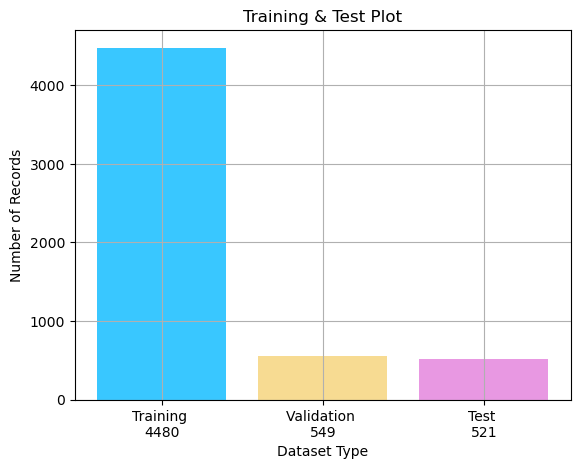

In [40]:
x_axis = ['Training \n{0}'.format(dataset_count[0]), 'Validation \n{0}'.format(dataset_count[1]), 'Test \n{0}'.format(dataset_count[2])]
y_axis = list(dataset_count)
plt.bar(x_axis, y_axis, color=['#39C7FF', '#F7DB92', '#E898E2'])
plt.title('Training & Test Plot')
plt.xlabel('Dataset Type')
plt.ylabel('Number of Records')
plt.grid()
plt.show()

In [41]:
pipeline_model = pipeline.fit(train) # training the Linear Regression
val_predictions = pipeline_model.transform(val)
#test_predictions = pipeline_model.transform(test)

In [83]:
test = test.na.drop() 
test_predictions = pipeline_model.transform(test)

For Validation

In [42]:
evaluator = RegressionEvaluator(
    labelCol = 'OBS_VALUE',
    predictionCol = 'prediction',
    metricName='rmse'
)

rmse = evaluator.evaluate(val_predictions)
print('RMSE: {0}'.format(rmse))

RMSE: 0.43305559517245895


In [86]:
evaluator = RegressionEvaluator(
    labelCol = 'OBS_VALUE',
    predictionCol = 'prediction',
    metricName='r2'
)
r2 = evaluator.evaluate(val_predictions)
print('R-squared:', r2)

R-squared: 0.257867474347119


For Test

In [84]:
evaluator = RegressionEvaluator(
    labelCol = 'OBS_VALUE',
    predictionCol = 'prediction',
    metricName='rmse'
)

rmse = evaluator.evaluate(test_predictions)
print('RMSE: {0}'.format(rmse))

RMSE: 0.42410941789432993


In [85]:
evaluator = RegressionEvaluator(
    labelCol = 'OBS_VALUE',
    predictionCol = 'prediction',
    metricName='r2'
)
r2 = evaluator.evaluate(test_predictions)
print('R-squared:', r2)

R-squared: 0.3218031940115833


In [44]:
lr_model = pipeline_model.stages[-1]
coefficients = lr_model.coefficients
intercept = lr_model.intercept
print(f"Coefficients: {coefficients}")
print(f"Intercept: {intercept}")

Coefficients: [0.031513399006997095,0.000797336659250646,2.521981993093973e-05]
Intercept: -1.8233873714499649


In [66]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

val2, train2 = val, train
train2, val2 = assembler.transform(train2), assembler.transform(val2)
train_pd = train2.select('features', 'OBS_VALUE').toPandas()
val_pd = val2.select('features', 'OBS_VALUE').toPandas()

# tried with this: max_iter=20000, epsilon=0.01
svr = SVR()
svr.fit(train_pd['features'].tolist(), train_pd['OBS_VALUE'])

predictions = svr.predict(val_pd['features'].tolist())

y_true = val_pd['OBS_VALUE'].tolist()

# Calculate the RMSE
mse = mean_squared_error(y_true, predictions)
rmse = np.sqrt(mse)

print("RMSE:", rmse)

# Calculate R-squared
r2 = r2_score(y_true, predictions)
print("R-squared:", r2)

RMSE: 0.4562016517424311
R-squared: 0.17641606917973263


In [77]:
test2 = test
test2 = test2.na.drop() 
test2 = assembler.transform(test2)

test_pd = test2.select('features', 'OBS_VALUE').toPandas()
predictions = svr.predict(test_pd['features'].tolist())

y_true = test_pd['OBS_VALUE'].tolist()

# Calculate the RMSE
mse = mean_squared_error(y_true, predictions)
rmse = np.sqrt(mse)

print("RMSE:", rmse)

# Calculate R-squared
r2 = r2_score(y_true, predictions)
print("R-squared:", r2)

RMSE: 0.4561342181996718
R-squared: 0.21551397129708016
